Для выполнения домашнего задания необходимо взять файл boston house-prices datase (sklearn.datasets.load_boston) и построить модель. По аналогии задания к лекции «Классификация: Логистическая регрессия и SVM». А именно построить модель регрессии, дерево решений, оптимизировать параметры и сравнить результаты.

In [43]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [44]:
data = pd.read_csv(load_boston()['filename'], skiprows=1)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Пропусков в даных нет, можно продолжать работу

#### Построим модель, не задавая гиперпараметры, ограничим только максимальную глубину дерева ####

In [46]:
clf = DecisionTreeRegressor(max_depth=4)

In [47]:
X, y = data.iloc[:, :-1], data['MEDV']

In [48]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=146)

In [49]:
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [50]:
y_pred = clf.predict(X_test)

In [51]:
mean_squared_error(y_pred, y_test)

20.393848515637963

In [52]:
clf.score(X_test, y_test)

0.6976715129737265

#### Обучим модель на том же разделении данных (c помощью GridSearchCV) ####

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
parameters = {'splitter':('best','random'), 
              'max_depth':np.arange(1,8), 
              'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(1,5)}

In [55]:
tree_grid = GridSearchCV(DecisionTreeRegressor(), parameters, cv = 7, n_jobs=-1)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([1, 2, 3, 4]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'splitter': ('best', 'random')})

In [56]:
tree_grid.best_params_

{'max_depth': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'splitter': 'random'}

In [57]:
best_tree = DecisionTreeRegressor(max_depth=6, min_samples_leaf=4, min_samples_split=2, splitter='random')

In [58]:
best_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=4, splitter='random')

In [59]:
y_pred_best = best_tree.predict(X_test)
best_tree.score(X_test, y_test)

0.7851887385433656

In [60]:
mean_squared_error(y_test, y_pred_best)

14.490292888671762

С новыми гиперпараметрами mse заметно уменьшилась, а точность предсказания увеличилась.

([<matplotlib.axis.YTick at 0xf93d5e0>,
 [Text(0, 0, 'CRIM'),
  Text(0, 1, 'ZN'),
  Text(0, 2, 'INDUS'),
  Text(0, 3, 'CHAS'),
  Text(0, 4, 'NOX'),
  Text(0, 5, 'RM'),
  Text(0, 6, 'AGE'),
  Text(0, 7, 'DIS'),
  Text(0, 8, 'RAD'),
  Text(0, 9, 'TAX'),
  Text(0, 10, 'PTRATIO'),
  Text(0, 11, 'B'),
  Text(0, 12, 'LSTAT')])

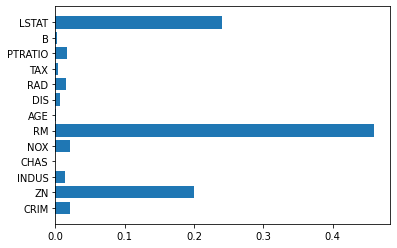

In [61]:
plt.barh(np.arange(len(best_tree.feature_importances_)), best_tree.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X.columns)

Наиболее важными оказались следующие показатели: LSTAT и RM.

#### Визуализируем само дерево ####

In [66]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(tree, feature_names=None, class_names=None):
    print(export_graphviz(tree, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [68]:
get_tree_dot_view(tree_grid.best_estimator_, X.columns)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="INDUS <= 5.665\nmse = 91.487\nsamples = 354\nvalue = 22.788", fillcolor="#f7d7c1"] ;
1 [label="RM <= 7.292\nmse = 75.577\nsamples = 100\nvalue = 29.251", fillcolor="#f2c19e"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="LSTAT <= 12.358\nmse = 35.313\nsamples = 84\nvalue = 26.483", fillcolor="#f4cbad"] ;
1 -> 2 ;
3 [label="RM <= 6.44\nmse = 34.123\nsamples = 77\nvalue = 26.936", fillcolor="#f4c9ab"] ;
2 -> 3 ;
4 [label="LSTAT <= 7.197\nmse = 5.673\nsamples = 30\nvalue = 21.97", fillcolor="#f7dac5"] ;
3 -> 4 ;
5 [label="LSTAT <= 6.404\nmse = 5.424\nsamples = 9\nvalue = 23.533", fillcolor="#f6d5bd"] ;
4 -> 5 ;
6 [label="mse = 6.822\nsamples = 5\nvalue = 24.22", fillcolor="#f6d3b9"] ;
5 -> 6 ;
7 [label="mse = 2.352\nsamples = 4\nvalue = 22.675", fillcolor="#f7d8c1"] ;
5 -> 7 ;
8 [label="PTRATIO <= 17.186\nmse = 4.284\nsamples = 21\nvalue = 21.3", fillcolor="#f8dcc9"] ;
4 -> 8 ;
9 [label=